In [2]:
!pip install pytorch-lightning #==1.2.8 --quiet
!pip install transformers #==4.5.1 --quiet
!pip install tensorflow
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#pytorch libraries 
import pytorch_lightning as pl
try:
    from torchmetrics.functional import accuracy, f1_score as f1, auroc
except ImportError:
    from pytorch_lightning.metrics.functional import accuracy, f1, auroc
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaTokenizerFast , BertConfig, BertModel,RobertaModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, plot_precision_recall_curve, precision_recall_curve

#Tensorflow libraries
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, concatenate, GlobalMaxPool1D, Conv1D, LSTM, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from itertools import cycle
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Input, ELU, Embedding, BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention

import numpy as np
import pandas as pd
import re
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import subprocess
import time
import datetime
import timeit

#import custom modules

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/DGA_Version_70length/')
import tf_models, data_utils, utils
from init import pt_initialize, tf_initialize
from dga_transformer import DGADataset, DGADataModule, DGATransformer

#jupyter setup
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#initialization
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)
root = '/content/drive/MyDrive/Colab Notebooks/DGA_Version_70length/'
related_models = ['highnam.h5', 'lstm1_mi.h5', 'n-CDBC.h5', 'ENSEMBLE_CNN_BILSTM.h5']


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:lightning_lite.utilities.seed:Global seed set to 42
INFO:lightning_lite.utilities.seed:Global seed set to 42


# **Binary Labeling**

In [6]:
amrita = data_utils.read_amrita(f'{root}data/multi', 'tf')
train_df, val_df, test_df = data_utils.read_amrita(f'{root}data/multi')
umudga_df = data_utils.read_data(f'{root}data/multi/biumudga_test.csv')
unknown_df = data_utils.read_data(f'{root}data/multi/unknown_dga.csv')
charbot_df = data_utils.read_data(f'{root}data/multi/charbotsamples.csv')

#read the alexa top 1 million non dga websites
alexa = data_utils.read_data(f'{root}data/multi/alexa.csv')
#split alexa for training and testing
alexa_test = alexa[0:15000]
alexa_train = alexa[15000:]

# **Multilabeling**

In [7]:
LABELS_NO = 21
mult_amrita = data_utils.read_amrita(f'{root}data/multi', 'tf', labels = LABELS_NO)
mtrain_df, mval_df, mtest_df = data_utils.read_amrita(f'{root}data/multi', labels = LABELS_NO)
mumudga_df = data_utils.read_data(f'{root}data/multi/biumudga_test.csv', labels = LABELS_NO)
munknown_df = data_utils.read_data(f'{root}data/multi/unknown_dga.csv', labels =  LABELS_NO)
mcharbot_df = data_utils.read_data(f'{root}data/multi/charbotsamples.csv', labels =  LABELS_NO)

#read the alexa top 1 million non dga websites
malexa = data_utils.read_data(f'{root}data/multi/alexa.csv', labels = LABELS_NO)
#split alexa for training and testing
malexa_test = malexa[0:15000]
malexa_train = malexa[15000:]

In [8]:
mult_amrita

,domain,benign,banjori,corebot,dircrypt,dnschanger,fobber,murofet,necurs,newgoz,...,pykspa,qadars,qakbot,ramdo,ranbyus,simda,suppobox,symmi,tempedreve,tinba
0,ccqekgftwpmlcfqtk.net,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,grqtgbglypyx.com,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,partymethod.net,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,5gbfree.com,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,fccjqnxxtwwcbxfcp.in,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397772,outsideniece.net,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
397773,abc-region-lax.vuemix.com,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397774,1h8aj6xgebb8s1wivxb9hqkpbq.org,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
397775,knxyqefnnfhyoalha.net,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# **Check dataset**

In [9]:
import seaborn as sns

In [10]:
amrita.head()

,domain,benign
0,ccqekgftwpmlcfqtk.net,0
1,grqtgbglypyx.com,0
2,partymethod.net,0
3,5gbfree.com,1
4,fccjqnxxtwwcbxfcp.in,0


In [11]:
trans_train = pd.concat([
  train_df,
  alexa_train.sample(n=(len(train_df[train_df['benign'] == 0])-len(train_df[train_df['benign'] == 1])), random_state=42)
]).reset_index(drop = True)
trans_train = trans_train.sample(n=400_000, random_state=42)
trans_train.head()

,domain,benign
477202,phpsupport.ir,1
190629,qbwravmxwvcj.com,0
235389,nrylvaxvptz.info,0
452280,telemax.com.mx,1
40214,aqjjdfqugygeoo.com,0


In [12]:
mtrans_train = pd.concat([
  mtrain_df,
  malexa_train.sample(n=(len(mtrain_df[mtrain_df['benign'] == 0])-len(mtrain_df[mtrain_df['benign'] == 1])), random_state=42)
]).reset_index(drop = True)
mtrans_train = mtrans_train.sample(n=400_000, random_state=42)
mtrans_train.fillna(value=0, inplace = True)
mtrans_train.head()


,domain,benign,banjori,corebot,dircrypt,dnschanger,fobber,murofet,necurs,newgoz,...,pykspa,qadars,qakbot,ramdo,ranbyus,simda,suppobox,symmi,tempedreve,tinba
477202,phpsupport.ir,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190629,qbwravmxwvcj.com,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
235389,nrylvaxvptz.info,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
452280,telemax.com.mx,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40214,aqjjdfqugygeoo.com,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
mamrita_columns = mtrain_df.columns.tolist()[1:] # 0 for DGA and 1 for benign 
print('benign \t', mtrans_train[mamrita_columns[0]].sum(axis=0))
mtrans_train[mamrita_columns[1:]].sum(axis=0)

benign 	 199969


banjori        10036.0
corebot        10151.0
dircrypt       10123.0
dnschanger     10114.0
fobber         10075.0
murofet        10080.0
necurs          8567.0
newgoz         10068.0
padcrypt       10104.0
proslikefan    10130.0
pykspa         10199.0
qadars         10119.0
qakbot         10073.0
ramdo          10128.0
ranbyus        10014.0
simda          10022.0
suppobox       10016.0
symmi           9987.0
tempedreve     10089.0
tinba           9936.0
dtype: float64

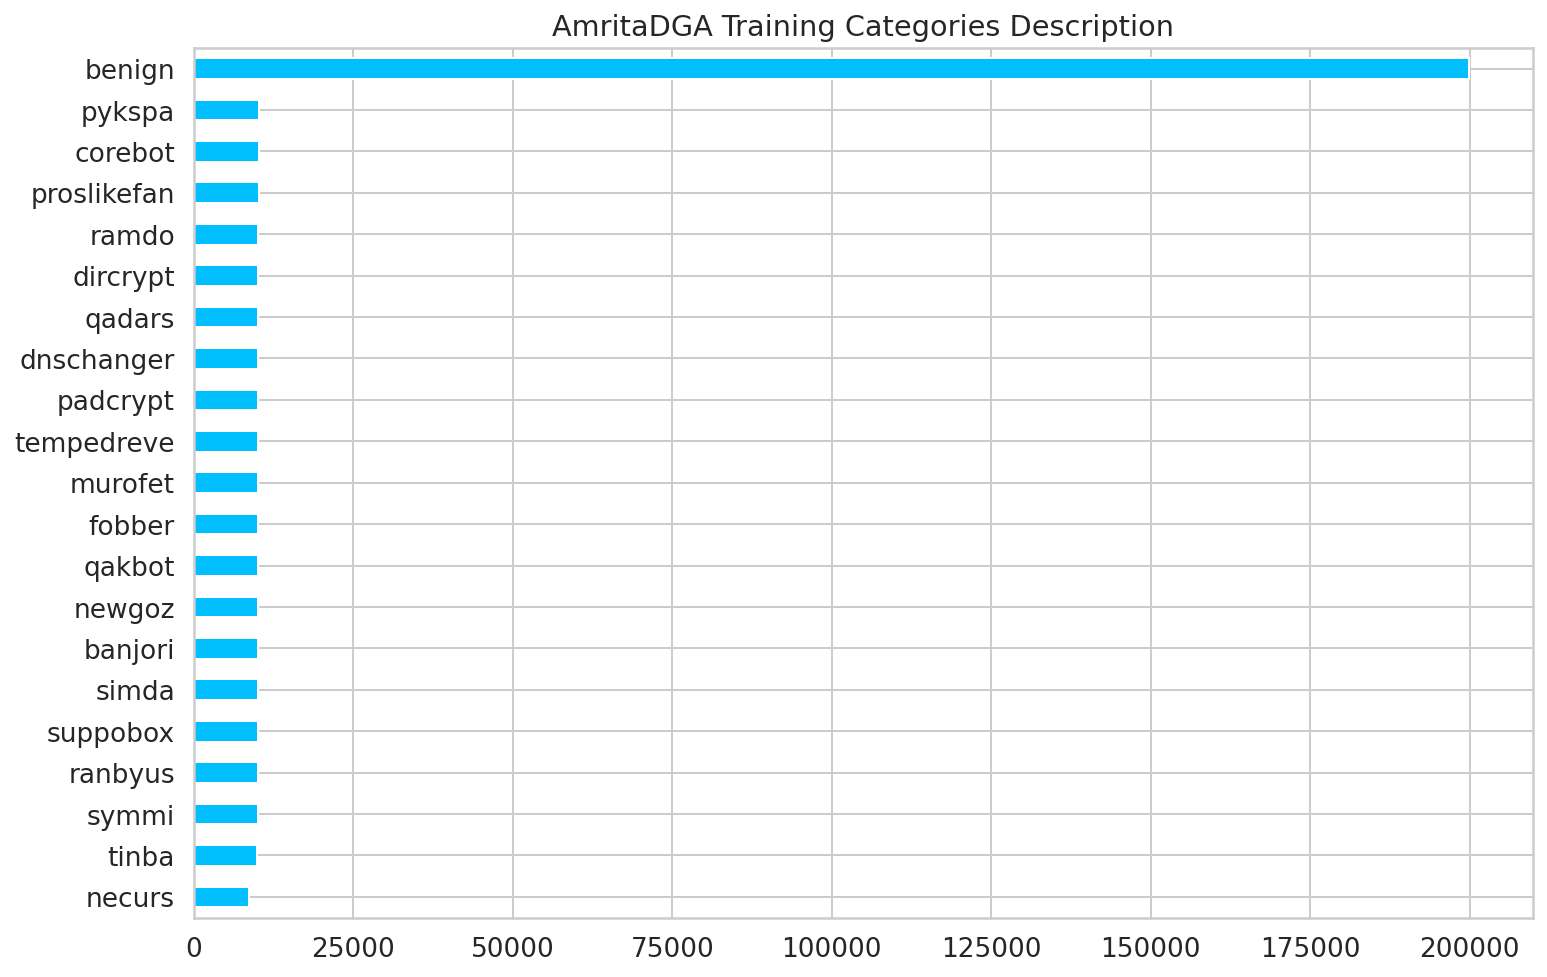

In [48]:
#plotting the whole data
LABEL_COLUMNS = mtrans_train.columns.tolist()[1:]
mtrans_train[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", title = 'AmritaDGA Training Categories Description');

'Dga: 200031 and benign: 199969, DGA is about 1.0 times higher'

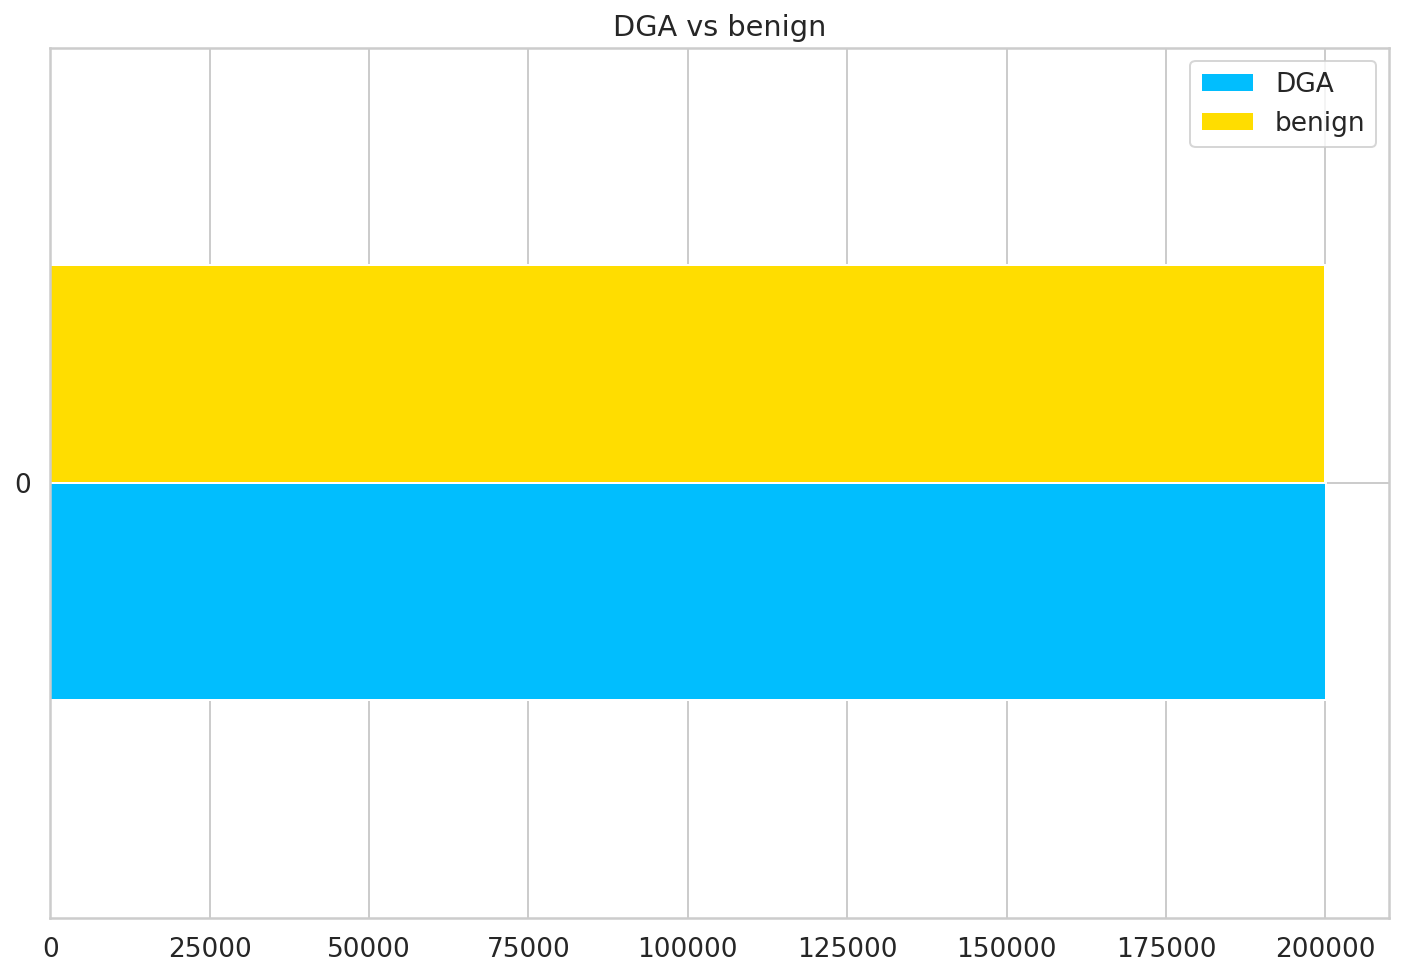

In [38]:
def plot_benign_vs_DGA(df, LABEL_COLUMNS):
    #Plot benign vs DGA
    data_dga = df[df[LABEL_COLUMNS[1:]].sum(axis=1) == 1]
    data_benign = df[df[LABEL_COLUMNS[0]] == 1]
    pd.DataFrame(dict(
      DGA=[len(data_dga)], 
      benign=[len(data_benign)]
    )).plot(kind='barh', title='DGA vs benign');
    return f'Dga: {len(data_dga)} and benign: {len(data_benign)}, DGA is about {round(len(data_dga)/len(data_benign), 2)} times higher'

#plotting the whole data
plot_benign_vs_DGA(mtrans_train, mtrans_train.columns.tolist()[1:])

In [45]:
trans_train['benign'].value_counts(), val_df['benign'].value_counts(), test_df['benign'].value_counts()

(0    200031
 1    199969
 Name: benign, dtype: int64, 0    26884
 1     8916
 Name: benign, dtype: int64, 0    29628
 1    10150
 Name: benign, dtype: int64)

In [44]:
umudga_df['benign'].value_counts(), unknown_df['benign'].value_counts(), alexa_test['benign'].value_counts()

(0    15000
 1    10000
 Name: benign, dtype: int64, 0    15214
 Name: benign, dtype: int64, 1    15000
 Name: benign, dtype: int64)

In [46]:
mtest_columns = mtest_df.columns.tolist()[1:] # 0 for DGA and 1 for benign 
print('benign \t', mtest_df[mtest_columns[0]].sum(axis=0))
mtest_df[mtest_columns[1:]].sum(axis=0)

benign 	 10150


banjori        1441
corebot        1466
dircrypt       1464
dnschanger     1501
fobber         1471
murofet        1518
necurs         1306
newgoz         1509
padcrypt       1513
proslikefan    1525
pykspa         1459
qadars         1530
qakbot         1422
ramdo          1515
ranbyus        1485
simda          1474
suppobox       1482
symmi          1541
tempedreve     1501
tinba          1505
dtype: int64

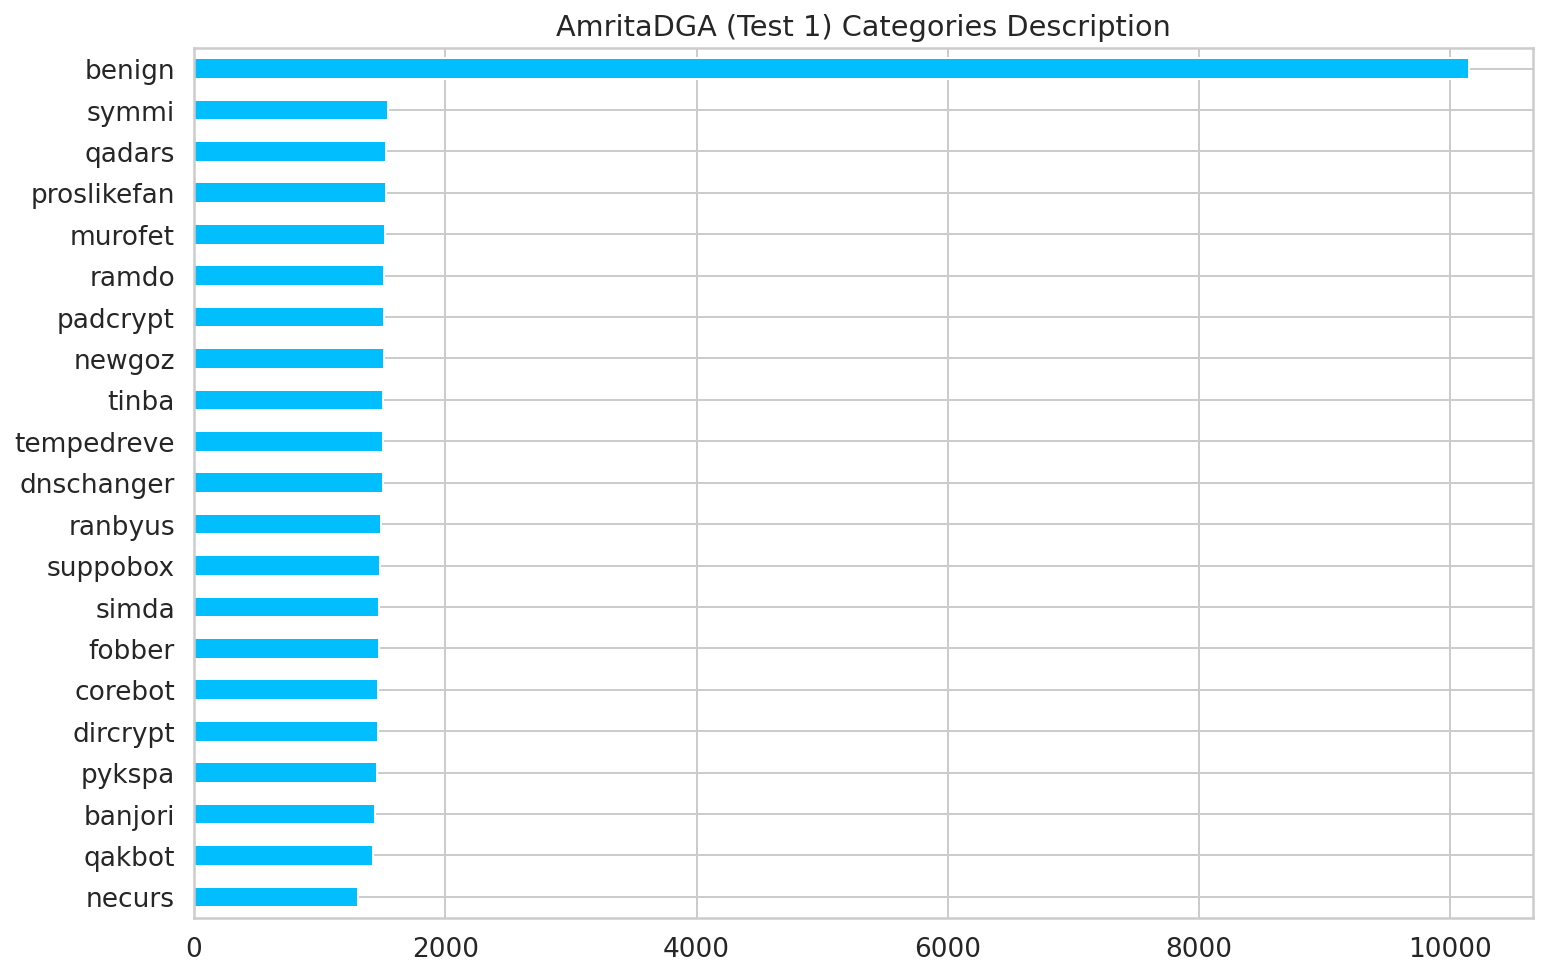

In [51]:
#plotting the whole data
LABEL_COLUMNS = mtest_df.columns.tolist()[1:]
mtest_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", title = 'AmritaDGA (Test 1) Categories Description');

In [52]:
mumudga_columns = mumudga_df.columns.tolist()[1:] # 0 for DGA and 1 for benign 
print('benign \t', mumudga_df[mumudga_columns[0]].sum(axis=0))
mumudga_df[mumudga_columns[1:]].sum(axis=0)

benign 	 10000


banjori        1000
corebot        1000
dircrypt       1000
dnschanger        0
fobber            0
murofet           0
necurs         1000
newgoz         1000
padcrypt       1000
proslikefan    1000
pykspa         1000
qadars         1000
qakbot         1000
ramdo          1000
ranbyus           0
simda          1000
suppobox          0
symmi          1000
tempedreve     1000
tinba          1000
dtype: int64

In [61]:
unknown_df = pd.concat([
  unknown_df,
  alexa_test.sample(n=14786, random_state = 42)
]).reset_index(drop = True)
unknown_df = unknown_df.sample(frac = 1).reset_index(drop=True) #shuffle data
unknown_df.head()

,domain,benign
0,8080.net,1
1,sport.pl,1
2,soncwjnfeuov.tech,0
3,q2o8o5r3ufb3k.info,0
4,google.co.nz,1


In [62]:
alexa_test.head()

,domain,benign
0,google.com,1
1,facebook.com,1
2,youtube.com,1
3,baidu.com,1
4,yahoo.com,1


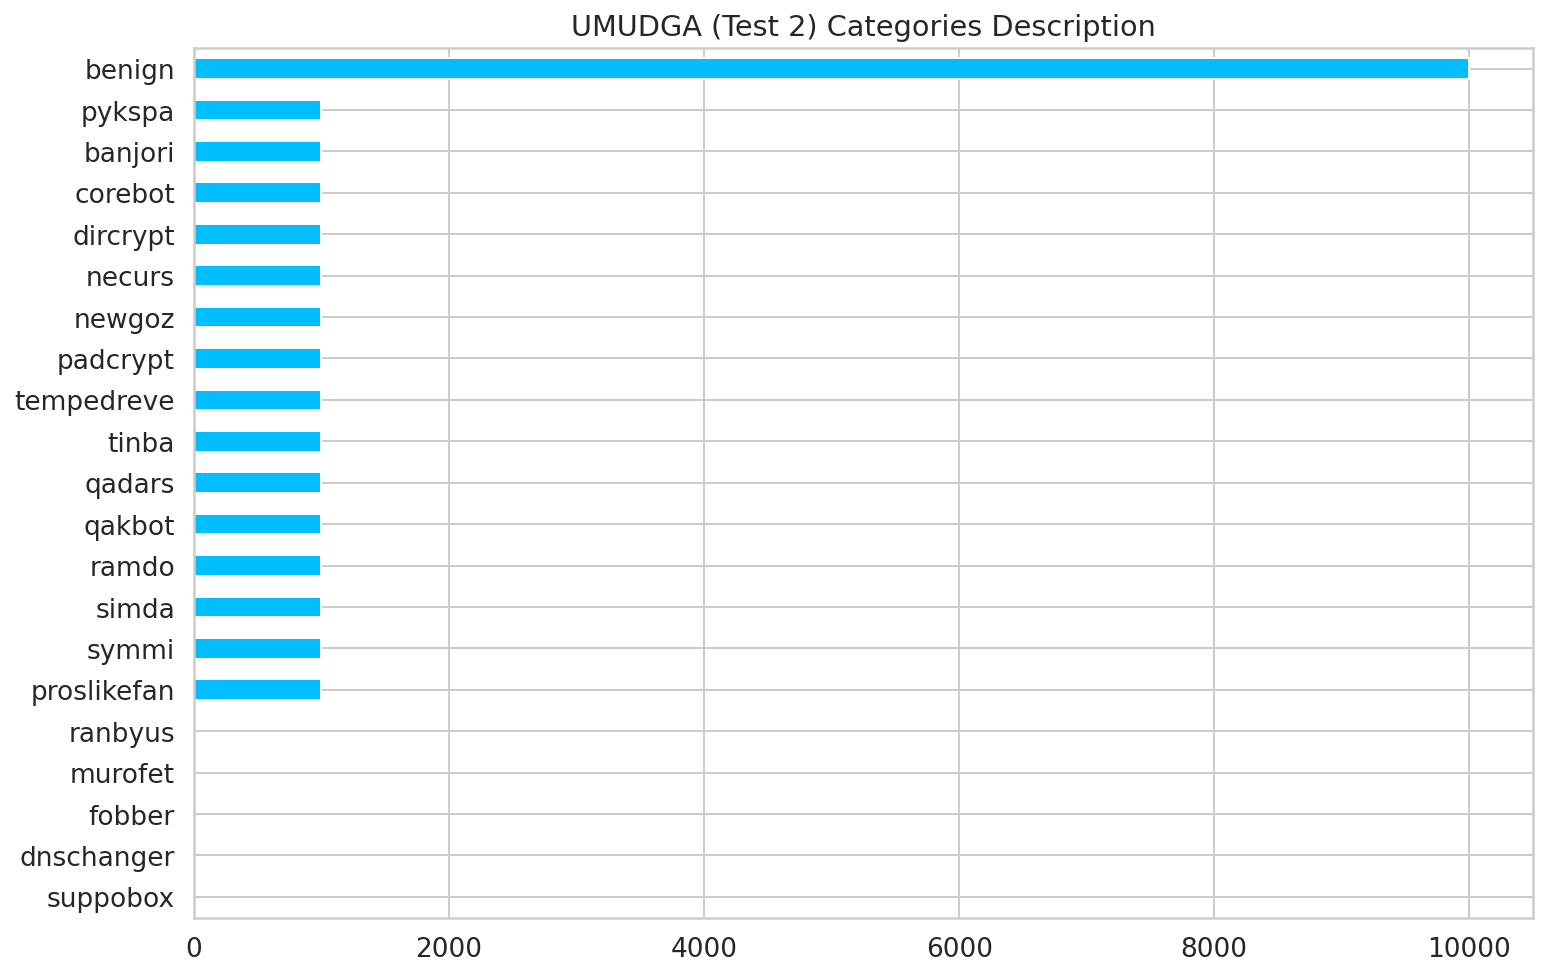

In [53]:
#plotting the whole data

LABEL_COLUMNS = mumudga_df.columns.tolist()[1:]
mumudga_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", title = 'UMUDGA (Test 2) Categories Description');

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


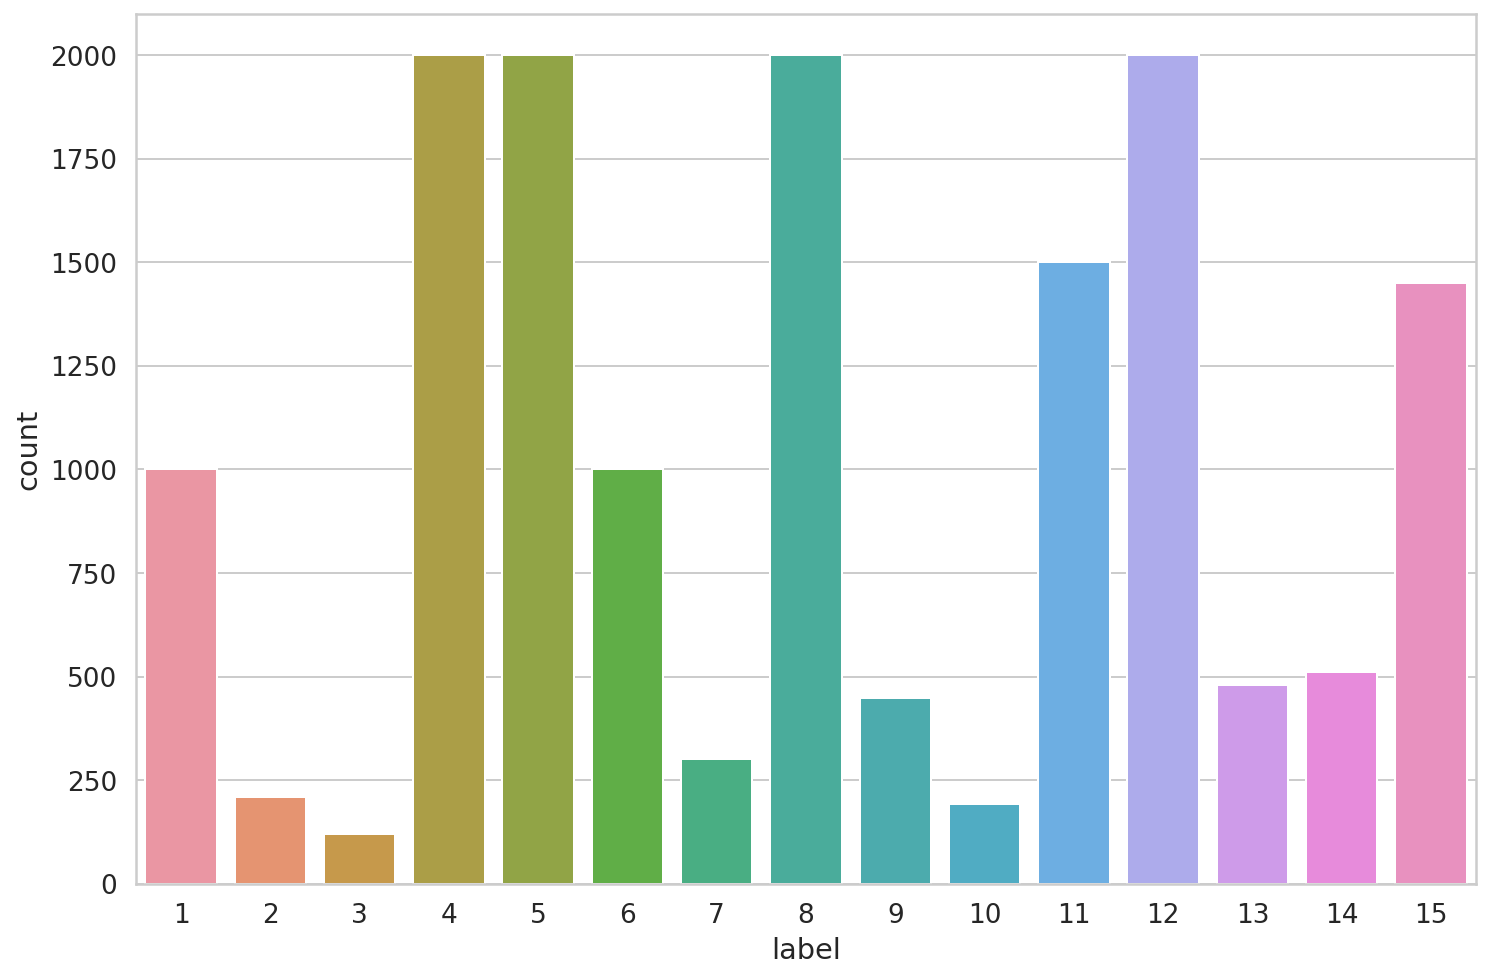

In [57]:

g = sns.countplot(munknown_df['label'])
plt.show()

In [58]:
munknown_df['label'].value_counts()

8     2000
4     2000
5     2000
12    2000
11    1500
15    1451
1     1001
6     1000
14     512
13     480
9      448
7      300
2      210
10     192
3      120
Name: label, dtype: int64

In [59]:
munknown_df['benign']

,domain,benign,label,version,family
0,ns1.dnsfor0.com,0,2,0,beebone_dga_ba4cafab
1,ns1.dnsfor0.org,0,2,0,beebone_dga_ba4cafab
2,ns1.dnsfor0.net,0,2,0,beebone_dga_ba4cafab
3,ns1.dnsfor0.biz,0,2,0,beebone_dga_ba4cafab
4,ns1.dnsfor0.info,0,2,0,beebone_dga_ba4cafab
